# Preliminary CIFAR-10 Analysis

Simple example using CIFAR-10 and a simple fast gradient sign attack.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import numpy as np
from scipy.stats import ks_2samp
import pylab as plt
import pandas as pd

from sklearn import svm
from sklearn.metrics import roc_curve, auc


from functools import reduce

In [2]:
df = pd.read_pickle(r"\\dom1\REDD\Groups\R1Q\Projects\AE_IRAD_2018\DataForEvan\Dec17\cifar10_stats_df.pkl")

print(df.dtypes.index)

datasets = pd.unique(df['Dataset'])
examples = pd.unique(df['Example#'])

print('frame has %d datasets and %d unique examples' % (len(datasets), len(examples)))
print(datasets)

Index(['boundary_distance', 'delta_loss', 'direction_id', 'direction_type',
       'k', 'y', 'y_hat', 'ell2_grad', 'Dataset', 'Example#', 'Approx_conf'],
      dtype='object')
frame has 8 datasets and 1264 unique examples
['cifar10' 'FGM-0.02' 'FGM-0.03' 'FGM-0.05' 'FGM-0.10' 'FGM-0.15'
 'FGM-0.20' 'FGM-0.25']


In [5]:
#Quick look at values appearing
print(df.k.value_counts())
print(df.y.value_counts())
print(df.y_hat.value_counts())

10.0    174040
5.0      87020
2.0      34808
Name: k, dtype: int64
3    79860
4    73524
6    70158
9    65142
1    58608
0    53856
5    53658
2    52074
8    39336
7    28116
Name: y, dtype: int64
6.0    120411
4.0     94153
2.0     53118
3.0     52501
9.0     37838
1.0     36898
8.0     36785
5.0     28279
0.0     25294
7.0     19632
Name: y_hat, dtype: int64


Notice already that the true examples are not uniformly distributed, but the boundary classes are more skewed.  It seems that class 6 shares more boundaries, while class 7 few.
Next, let's look at how the distance to the decision boundary is distributed

In [21]:
#replace infinities so we can show histograms.  Treat not finding a boundary distance as if it would take twice the distance we looked.
d_max = round(df.boundary_distance[df.boundary_distance != np.inf].max())
df.replace(np.inf, 2 * d_max, inplace=True)

In [24]:
plt.rcParams['figure.figsize'] = (16,9)

In [22]:
print(d_max)
df.describe()

19.9993799988


,boundary_distance,delta_loss,direction_id,k,y,y_hat,ell2_grad,Example#,Approx_conf
count,574332.000000,504909.000000,147934.000000,295868.000000,574332.000000,504909.000000,5.743320e+05,574332.000000,574332.000000
mean,8.512894,0.678139,3.294118,7.588235,4.324063,4.581729,1.333143e+00,743.541255,5.940929
std,12.619301,0.228957,2.781560,3.010942,2.787384,2.458596,2.177681e+00,429.864006,4.622780
min,0.000620,-0.647417,0.000000,2.000000,0.000000,0.000000,1.509211e-12,0.000000,0.000379
25%,0.527621,0.627836,1.000000,5.000000,2.000000,3.000000,3.061312e-03,375.000000,2.185725
50%,2.292765,0.692985,3.000000,10.000000,4.000000,4.000000,1.361213e-01,733.000000,4.908613
75%,10.508401,0.766593,5.000000,10.000000,6.000000,6.000000,1.798163e+00,1115.000000,8.683886
max,39.998760,1.809731,9.000000,10.000000,9.000000,9.000000,1.217909e+01,1499.000000,29.178455


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002194C90D588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002194CC38860>]], dtype=object)

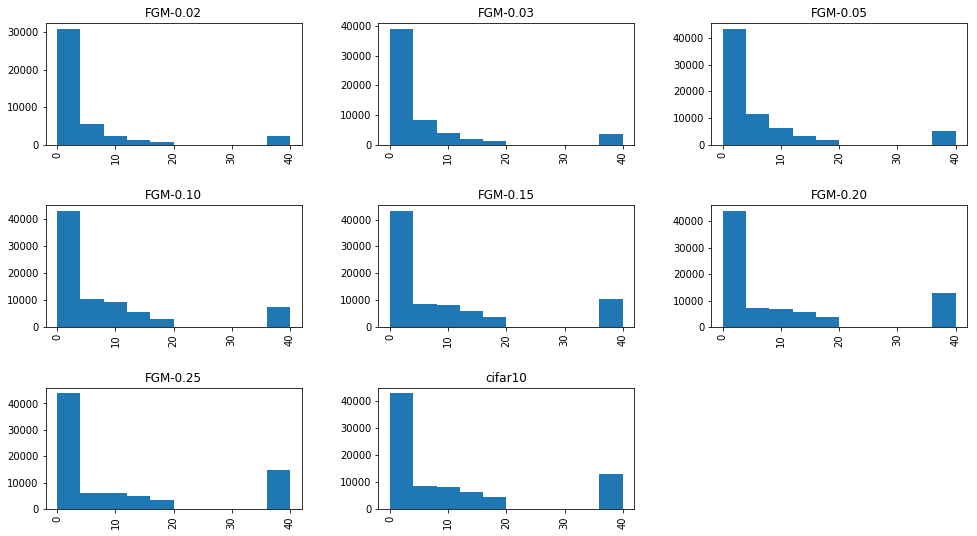

In [25]:
df.hist('boundary_distance', by='Dataset')

In [26]:
grouped = df.groupby(['Dataset', 'direction_type'])

In [42]:
plot_vals = grouped.boundary_distance.mean()
plot_df = plot_vals.unstack('Dataset')

'''
fig, ax = plt.subplots()
for col in grouped.boundary_distance.mean():
    col.plot(ax=ax)
#grouped.boundary_distance.mean().plot(stacked=True, legend=True)
'''

'\nfig, ax = plt.subplots()\nfor col in grouped.boundary_distance.mean():\n    col.plot(ax=ax)\n#grouped.boundary_distance.mean().plot(stacked=True, legend=True)\n'

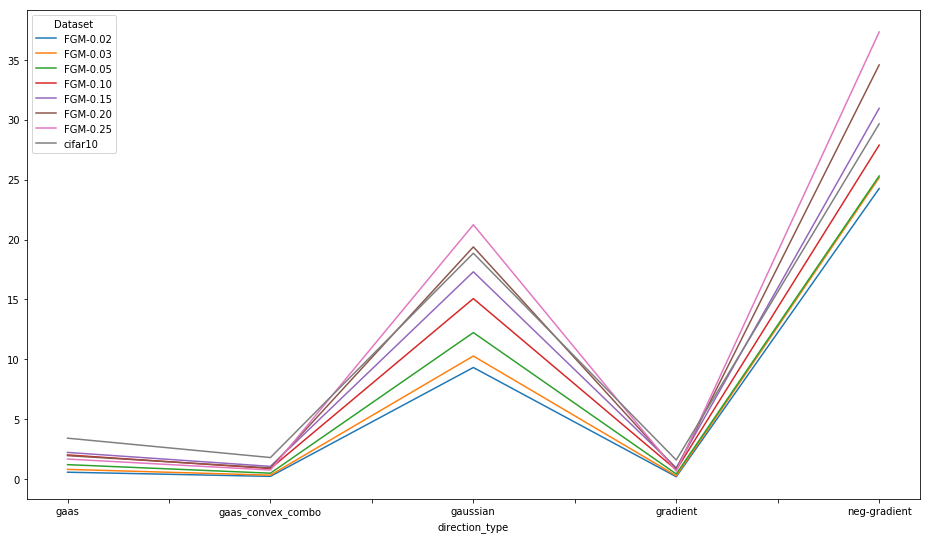

In [47]:
plot_df.plot(sort_columns=['direction_type'])

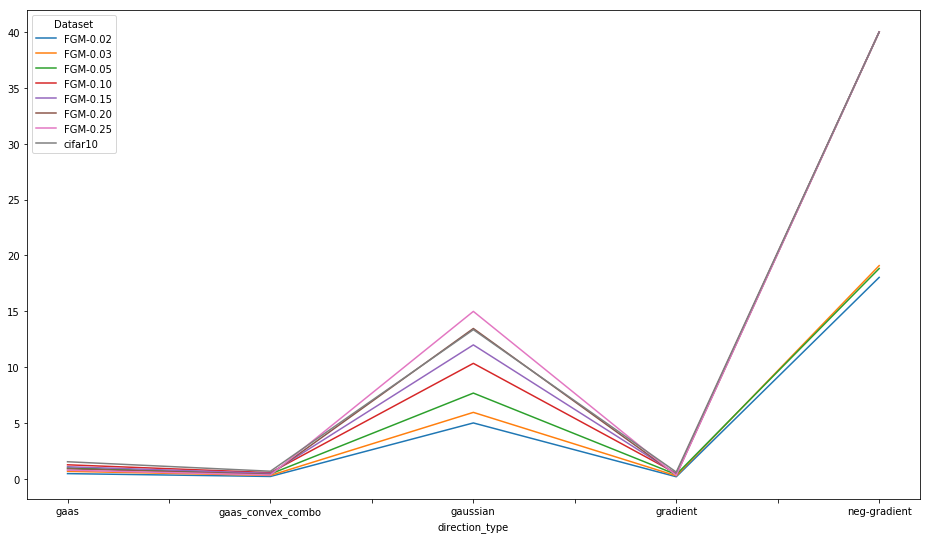

In [48]:
grouped.boundary_distance.median().unstack('Dataset').plot()

In [62]:
counts = df.groupby(['y', 'y_hat']).ell2_grad.count()

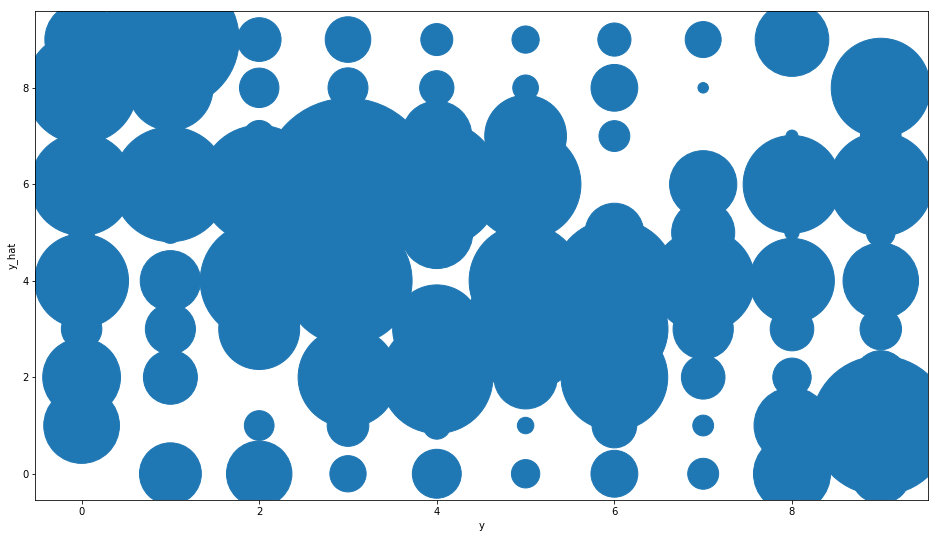

In [72]:
counts.reset_index().plot.scatter('y', 'y_hat', s = counts)

In [90]:
purity_group = df[df.direction_type == 'gaussian'].groupby(['Example#', 'Dataset'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021902981128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000219046AE8D0>]], dtype=object)

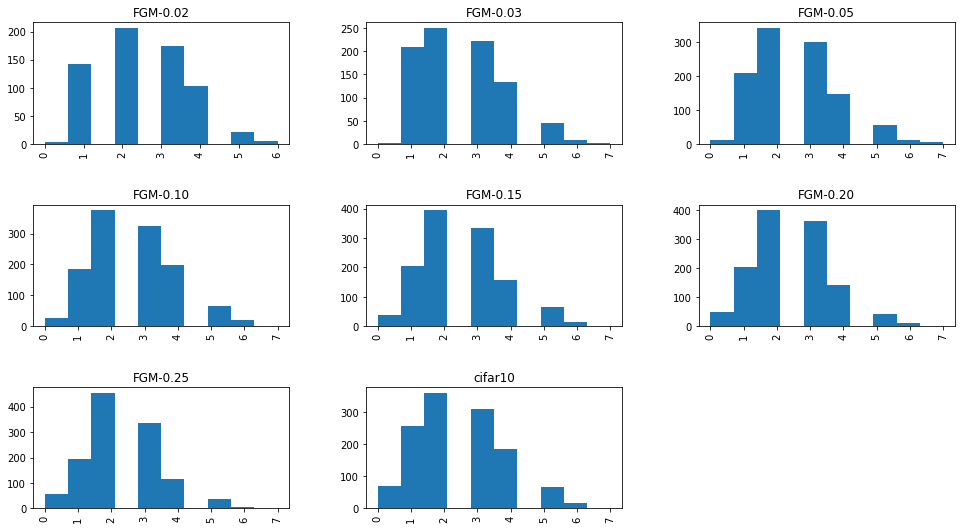

In [96]:
purity_group.y_hat.nunique().hist(by='Dataset')

In [154]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show

In [156]:
output_notebook()

Loading BokehJS ...

In [157]:
p = figure(title='Distance to boundary vs change in loss, by starting point')
p.scatter(close.boundary_distance, close.delta_loss)

GlyphRenderer(id='3f2c00da-20a9-4236-8e62-f9345db8248d', ...)

In [159]:
show(p)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


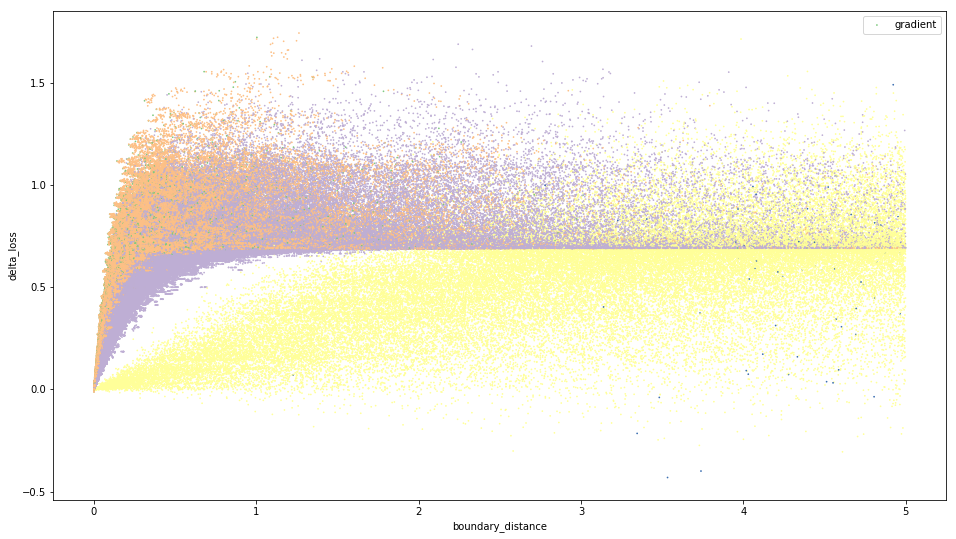

In [161]:
type_index = {j:i for i, j in enumerate(close.direction_type.unique())}
close.plot.scatter('boundary_distance', 'delta_loss', by = 'direction_type', c = plt.cm.Accent(close.direction_type.map(type_index)), s=0.5)
plt.legend(type_index.keys())

In [ ]:
close = df[df.boundary_distance < 5]
plt.scatter(close.boundary_distance, close.delta_loss, c = close.direction_type.map(type_index), label = close.direction_type, s = 0.5, legend=True)
#plt.legend()

In [105]:
df.head()

,boundary_distance,delta_loss,direction_id,direction_type,k,y,y_hat,ell2_grad,Dataset,Example#,Approx_conf
0,0.454461,0.712274,NaN,gradient,NaN,3,5.0,0.065442,cifar10,0,5.612053
1,17.793416,0.762305,NaN,neg-gradient,NaN,3,2.0,0.065442,cifar10,0,5.612053
2,14.697129,0.819046,NaN,gaussian,NaN,3,6.0,0.065442,cifar10,0,5.612053
3,13.820448,0.760737,NaN,gaussian,NaN,3,6.0,0.065442,cifar10,0,5.612053
4,14.414409,0.811234,NaN,gaussian,NaN,3,4.0,0.065442,cifar10,0,5.612053
